# Getting the data
#### **Summary:** *This code segment is designed to import the document file(s) that contain the clinical trial data. This code demonstrates how to load and process data from an Excel file using the Pandas library in Python. Specifically, it focuses on loading an Excel file containing multiple sheets, retrieving the names of the sheets, and extracting specific sheets into separate DataFrames.*

#### **Data Loading:** 
The code uses the `read_excel` function from the Pandas library to load an Excel file (`synthetic_participant_dose_data.xlsx`) into a dictionary of DataFrames. By specifying `sheet_name=None`, all sheets in the Excel file are loaded into the dictionary.  
  
#### **Sheet Names Retrieval:**  
After loading the Excel file, the code retrieves the names of all potential sheets by joining the keys of the DataFrame dictionary into a single string. In case the names of the sheets is not known, this will help discover which sheets contain which information.
  
#### **Specific Sheets Extraction:**
Using the `sheet_name` argument of the `read_excel` function, the code extracts specific sheets, such as "participants" and "doses", into separate DataFrames.  
  
#### **Missing Values Check (Optional)**  
The code includes a commented-out line (`print(doses.isna().any())`) that can be used to check for missing values in one of the loaded DataFrames.  If uncommented, it would display a Boolean series indicating whether each column in the "doses" DataFrame contains missing values. This can be changed to check any sheet for missing values, should they be relevant. If any missing values are found, further steps might be taken to handle or remove them as necessary.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

###LOAD IN THE SHEET
dataframe = pd.read_excel('../data/synthetic_participant_dose_data.xlsx',sheet_name=None)

###GET THE NAMES OF ALL OF THE POTENTIAL SHEETS
sheet_names = ", ".join(dataframe.keys())
print(f"Sheet names = {sheet_names}")

###Get the sheets you want
participants = pd.read_excel('../data/synthetic_participant_dose_data.xlsx',sheet_name='participants')
doses = pd.read_excel('../data/synthetic_participant_dose_data.xlsx',sheet_name='doses')

###check for missing values and remove those
#print(doses.isna().any())

Sheet names = participants, doses, data dictionary


# Filtering for clinical trial participation and adverse events 

#### **Summary:** *This analysis offers insights into the prevalence of adverse events among participants who completed the clinical trial. The visualization helps understand the proportion of participants affected by adverse events relative to the total number of participants in the trial.*

#### **Participant Filtering:** 
Participants who met the inclusion criteria, were not excluded, were accepted, started, and finished the trial are filtered from the `participants` DataFrame. This ensures that only participants who completed the trial under suitable conditions are considered.
#### **Merging Dataframes:** 
The relevant information about these full participants is merged with dose information based on the ParticipantID, resulting in the `full_participant_info` DataFrame.
#### **Converting Administration Date:** 
The `AdministrationDate` column is converted to datetime format to facilitate further analysis. The data is sorted by `ParticipantID` and `AdministrationDate`.
#### **Counting Adverse Events:** 
The code counts the number of unique patients who experienced adverse events (`SeverityOfAdverseEvents` is not null) among the full participants. It also calculates the total number of unique patients in the trial.
#### **Visualization:** 
A pie chart is generated to visually represent the proportion of patients who experienced adverse events compared to those who did not. The chart is labeled with percentages to provide clear insights into the distribution of adverse events among participants.

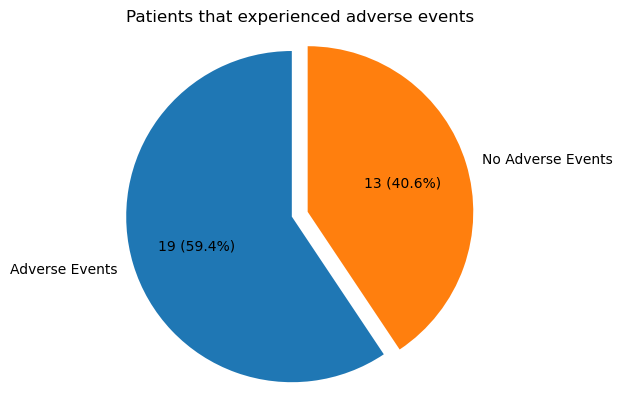

In [5]:
###get everyone who completed the trial
included_participants = participants["InclusionCriteriaMet"] == 1 ##included
not_excluded_participants = participants["ExclusionCriteriaMet"] == 0  ##not excluded
accepted_participants = participants["Accepted"] == 1
started_participants = participants["Started"] == 1
finished_participants = participants["Finished"] == 1
full_participants = participants[included_participants & not_excluded_participants & accepted_participants & started_participants & finished_participants]

full_participant_info = pd.merge(full_participants, doses, on = "ParticipantID", how = "inner")

##convert Administration date to datetime
full_participant_info = full_participant_info.sort_values(by = ['ParticipantID', 'AdministrationDate'])
full_participant_info["updated_dose_number"] = full_participant_info.groupby('ParticipantID').cumcount() + 1

##count unique patients with adverse events
patients_w_adverse = full_participant_info.loc[~full_participant_info['SeverityOfAdverseEvents'].isna(), 'ParticipantID'].nunique()
total_unique_patients = full_participant_info['ParticipantID'].nunique()
percentage_patients_with_adverse_events = (patients_w_adverse/total_unique_patients) * 100
##visualization
labels = ['Adverse Events', 'No Adverse Events']
sizes = [patients_w_adverse, total_unique_patients-patients_w_adverse]
explode = (0.1, 0)
plt.pie(sizes, explode=explode, labels=labels, autopct=lambda p: '{:.0f} ({:.1f}%)'.format(p * sum(sizes) / 100, p), startangle=90)
plt.title('Patients that experienced adverse events')
plt.axis('equal')
plt.show()
plt.close()

# Analyzing Frequency of Adverse Events by Severity

#### **Summary:** *This code aims to analyze the frequency of adverse events categorized by severity, using the `full_participant_info` dataset.*

#### **Data Preparation:**

-   The dataset is filtered to include only rows where adverse events are reported (`SeverityOfAdverseEvents` column is not null).
    
-   The count of adverse events for each severity level is computed using the `value_counts()` function.
    
-   The total number of adverse events is calculated by summing up the counts across all severity levels.
    

#### **Visualization:**

-   A bar plot is created to visualize the frequency of adverse events for each severity level.
    
-   x-axis: the severity of adverse events, y-axis: denotes the frequency of occurrence.
        

#### **Conclusion:** *This visualization provides insights into the distribution of adverse events across different severity levels.*

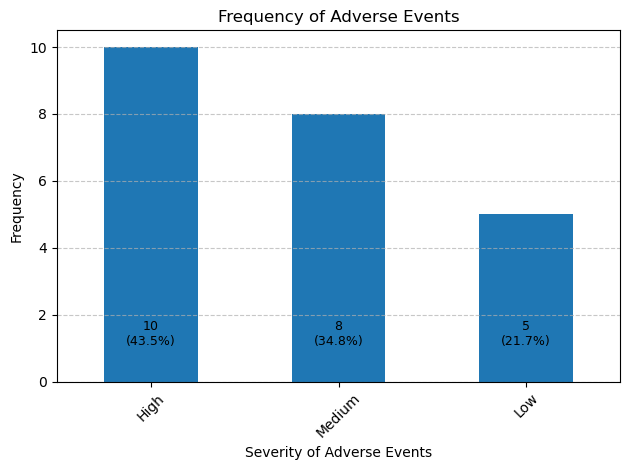

In [6]:
#Filtering the dataframe to include only rows with reported adverse events
adverse_events = full_participant_info[full_participant_info['SeverityOfAdverseEvents'].notna()]
adverse_events_counts = adverse_events['SeverityOfAdverseEvents'].value_counts()
total_adverse_events = adverse_events_counts.sum()
adverse_events_percentages = (adverse_events_counts / total_adverse_events) * 100
adverse_events_counts.plot(kind='bar')
for i, count in enumerate(adverse_events_counts):
    plt.text(i, 1, f'{count}\n({adverse_events_percentages[i]:.1f}%)',
             ha='center', va='bottom', fontsize=9)
plt.title('Frequency of Adverse Events')
plt.xlabel('Severity of Adverse Events')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
plt.close()

# Analyzing Number of Adverse Events per Patient
  
#### **Summary:** *This code aims to analyze the distribution of the number of adverse events experienced by each patient, utilizing the full_participant_info dataset.*
    
#### **Data Filtering:**

-   The dataset is filtered to include only rows where adverse events are reported (`SeverityOfAdverseEvents` column is not null).
    

#### **Grouping and Counting:**

-   The filtered data is then grouped by `ParticipantID`, and the size of each group (i.e., the count of adverse events per patient) is calculated.
    
-   Occurrences of each count of adverse events per patient are counted,
    

#### **Visualization:**

-   A bar plot is created to visualize the distribution of the number of adverse events per patient.
    
    
-   x-axis: number of adverse events per patient, y-axis: the number of patients.
    

#### **Conclusion:** *This visualization shows the distribution of adverse events experienced by patients.*

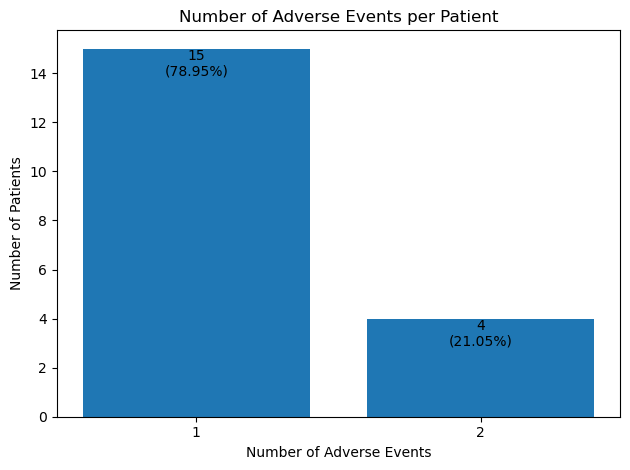

In [7]:
#Filtering the dataframe to include only rows with reported adverse events
adverse_events = full_participant_info[full_participant_info['SeverityOfAdverseEvents'].notna()]
#Grouping the data by patient and counting occurrences
adverse_events_per_patient = adverse_events.groupby('ParticipantID').size()
#Counting occurences of number of adverse events
adverse_events_count = adverse_events_per_patient.value_counts().sort_index()
#Plot
bar_plot = plt.bar(adverse_events_count.index, adverse_events_count.values)
total_patients = adverse_events_per_patient.count()
for bar in bar_plot:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height}\n({(height / total_patients * 100):.2f}%)',
             ha='center', va='top')
plt.title('Number of Adverse Events per Patient')
plt.xlabel('Number of Adverse Events')
plt.ylabel('Number of Patients')
plt.xticks([1,2])
plt.tight_layout()
plt.show()

# Analyzing Frequency of Adverse Events by Duration
  #### **Summary:** *This code focuses on analyzing the frequency of adverse events based on their duration.*  
  #### **Data Filtering:**  
  
-   The dataset is filtered to include only rows where the duration of adverse events (`DurationOfAdverseEvents`) is not zero.    

#### **Calculating Counts and Percentages:**  
  
-   After filtering, the frequency of adverse events for each duration is counted using the `value_counts()` function.
        
-   Total adverse events are calculated by summing up the counts and percentages for each duration were calculated.
        
#### **Visualization:**  
  
-   A bar plot is created to visualize the frequency of adverse events across different durations.
        
-   x-axis: the duration of adverse events in days; y-axis: the frequency of occurrences.
      
#### **Summary:** *This visualization shows the distribution of adverse events over different durations.*

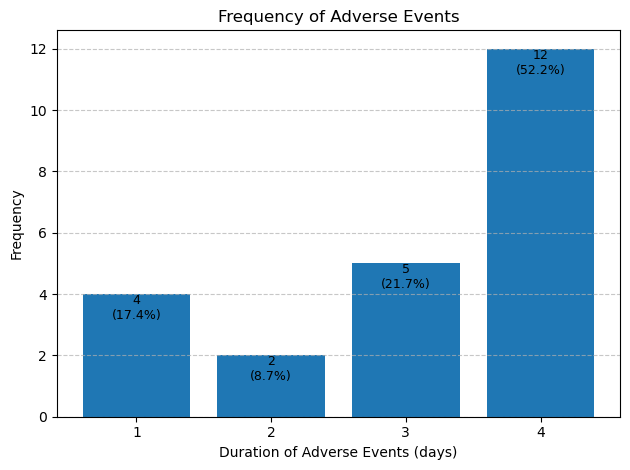

In [8]:
#Filtering the dataframe to include only rows with reported adverse events
adverse_events = full_participant_info[full_participant_info['DurationOfAdverseEvents'] != 0]
adverse_events_counts = adverse_events['DurationOfAdverseEvents'].value_counts()
adverse_events_counts = adverse_events_counts.sort_index()
total_adverse_events = adverse_events_counts.sum()
adverse_events_percentages = (adverse_events_counts / total_adverse_events) * 100
adverse_events_counts_sorted = adverse_events_counts.sort_index()

# Reset the index
adverse_events_counts_sorted = adverse_events_counts_sorted.reset_index(drop=True)

# Create bar plot
plt.bar(range(len(adverse_events_counts_sorted)), adverse_events_counts_sorted)

# Add text labels
for i, count in enumerate(adverse_events_counts_sorted):
    plt.text(i, count, f'{count}\n({adverse_events_percentages.iloc[i]:.1f}%)',
             ha='center', va='top', fontsize=9)

plt.title('Frequency of Adverse Events')
plt.xlabel('Duration of Adverse Events (days)')
plt.ylabel('Frequency')
plt.xticks(range(len(adverse_events_counts_sorted)), adverse_events_counts_sorted.index + 1, rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Analyzing Adverse Events by Duration and Severity
  #### **Summary:** *This code focuses on analyzing adverse events based on their duration and severity, utilizing a dataset named full_participant_info.* 
  #### **Data Filtering:**  
  
-   The code filters the dataset to include only those rows where the severity of adverse events is not missing (`notna()`) and the duration of adverse events is non-zero (`!= 0`).

#### **Data Grouping:**  
  
-   After filtering, the data is grouped by both the duration of adverse events (`DurationOfAdverseEvents`) and the severity of adverse events (`SeverityOfAdverseEvents`).
    
-   The `groupby()` function is used to group the data based on these two columns, and the `size()` function counts the occurrences of each combination of duration and severity.
    
-   The `unstack()` method rearranges this grouped data into a tabular format, with severity levels as columns and durations as rows.
    
#### **Visualization:**  
  
-   The grouped data is plotted using a stacked bar plot to visualize the frequency of adverse events based on their duration and severity.
    
-   x-axis: the duration of adverse events in days; y-axis: the frequency of occurrences.
    
  
#### **Summary:** *This visualization shows insights into the distribution and severity of adverse events over different durations*

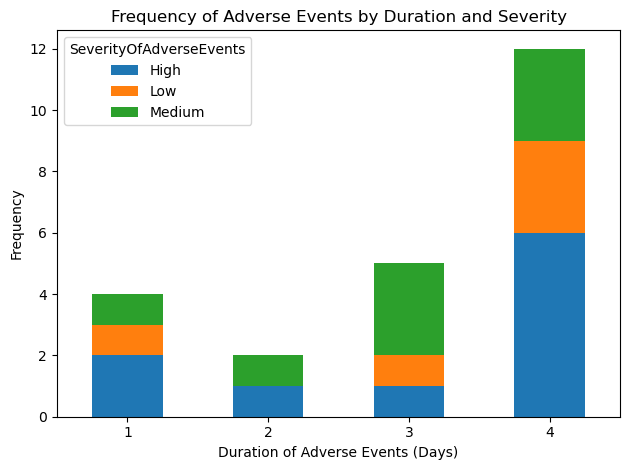

In [9]:
#####length of adverse events based on severity
filtered_data = full_participant_info[(full_participant_info['SeverityOfAdverseEvents'].notna()) & (full_participant_info['DurationOfAdverseEvents'] != 0)]

# Group data by duration and severity, and count occurrences
grouped_data = filtered_data.groupby(['DurationOfAdverseEvents', 'SeverityOfAdverseEvents']).size().unstack(fill_value=0)

# Plotting
grouped_data.plot(kind='bar', stacked=True)

# Set labels and title
plt.title('Frequency of Adverse Events by Duration and Severity')
plt.xlabel('Duration of Adverse Events (Days)')
plt.ylabel('Frequency')
plt.xticks(rotation=0)

# Show plot
plt.tight_layout()
plt.show()
plt.close()

# Analyzing Adverse Events by Dose Number and Severity
  #### **Summary:** *This code shows adverse events based on the dose number administered to patients and the severity of adverse events they experienced.* 

#### **Data Processing:**  
  
-   The code filters the dataset to include only rows where the severity of adverse events is not missing (`notna()`).
    
-   Next, it groups the filtered data by both the dose number (`updated_dose_number`) and the severity of adverse events (`SeverityOfAdverseEvents`).
    
-   The `size()` function calculates the number of occurrences for each combination of dose number and severity.
    
-   The `unstack()` method reorganizes this data to create a stacked bar plot, with each dose number represented by a separate bar and different severity levels stacked within each bar.
    
#### **Visualization:**  
  
-   The code shows a stacked bar plot to see the distribution of adverse events across different dose numbers and severity levels.
    
-   x-axis: the dose number; y-axis: number of adverse events.
    
-   Each bar corresponds to a specific dose number, and different colors indicate severity levels of adverse events within each dose category.
    
  
#### **Summary:** *The plot shows the relationship between dose number, severity of adverse events, and their overall distribution.*

In [ ]:
adverse_events = full_participant_info[full_participant_info['SeverityOfAdverseEvents'].notna()]
grouped_data = adverse_events.groupby(['updated_dose_number', 'SeverityOfAdverseEvents']).size().unstack(fill_value=0)
grouped_data.plot(kind='bar', stacked=True)
plt.title('Adverse Events by Dose Number and Severity')
plt.xlabel('Dose Number')
plt.ylabel('Number of Adverse Events')
plt.xticks(rotation=0)

# Show plot
plt.tight_layout()
plt.show()
plt.show()
plt.close()